# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

[Te proporcionamos algunos comentarios para orientarte mientras completas este proyecto. Pero debes asegurarte de eliminar todos los comentarios entre corchetes antes de entregar tu proyecto.]

[Antes de sumergirte en el análisis de datos, explica por tu propia cuenta el propósito del proyecto y las acciones que planeas realizar.]

[Ten en cuenta que estudiar, modificar y analizar datos es un proceso iterativo. Es normal volver a los pasos anteriores y corregirlos/ampliarlos para permitir nuevos pasos.]

## Inicialización

In [1]:
# Cargar todas las librerías
from scipy import stats as st
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind


## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
df_users = pd.read_csv("/datasets/megaline_users.csv")
df_calls = pd.read_csv("/datasets/megaline_calls.csv")
df_messages = pd.read_csv("/datasets/megaline_messages.csv")
df_internet = pd.read_csv("/datasets/megaline_internet.csv")
df_plans = pd.read_csv("/datasets/megaline_plans.csv")

## Preparar los datos

[Los datos para este proyecto se dividen en varias tablas. Explora cada una para tener una comprensión inicial de los datos. Si es necesario, haz las correcciones requeridas en cada tabla.]

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas

df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprime una muestra de los datos para las tarifas

print(df_plans.head())

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


### Revisión inicial de la tabla "df_plans"


Al revisar la información general del archivo megaline_plans.csv mediante el método .info(), se observa que el conjunto de datos contiene únicamente 2 registros, correspondientes a los dos planes disponibles: Surf y Ultimate. No se detectan valores nulos en ninguna de las columnas, lo cual es una buena señal.

En cuanto a los tipos de datos, todos parecen apropiados: los valores numéricos como precios, límites de uso y tarifas adicionales están correctamente representados como int64 o float64, mientras que los nombres de los planes aparecen como objetos (cadenas de texto).

La muestra de datos (.head()) confirma que la estructura es clara y que los nombres de columna son entendibles, aunque un poco técnicos. Por eso, para facilitar el análisis posterior, opté por renombrar algunas columnas, por ejemplo:

usd_monthly_pay → monthly_fee_(USD)

mb_per_month_included → data_included_(MB)
Esto mejora la legibilidad sin alterar la estructura del archivo original.

No hay problemas evidentes que requieran limpieza profunda, pero la conversión de los megabytes incluidos a gigabytes puede facilitar comparaciones más claras en etapas posteriores del análisis.

## Corregir datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [5]:
df_plans.rename(columns={
    "usd_monthly_pay": "monthly_fee_(USD)",
    "mb_per_month_included": "data_included_(MB)",
    "usd_per_gb": "cost_per_GB_(USD)",
    "usd_per_message": "cost_per_message_(USD)",
    "usd_per_minute": "cost_per_minute_(USD)"
}, inplace=True)

print(df_plans.head())

   messages_included  data_included_(MB)  minutes_included  monthly_fee_(USD)  \
0                 50               15360               500                 20   
1               1000               30720              3000                 70   

   cost_per_GB_(USD)  cost_per_message_(USD)  cost_per_minute_(USD) plan_name  
0                 10                    0.03                   0.03      surf  
1                  7                    0.01                   0.01  ultimate  


## Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [6]:
# Convertir los MB incluidos a GB (para comparaciones más prácticas)
df_plans["data_included_(GB)"] = df_plans["data_included_(MB)"] / 1024

# Crear una columna descriptiva que resuma el contenido de cada plan
df_plans["description"] = (
    df_plans["plan_name"].str.capitalize() + ": " +
    df_plans["minutes_included"].astype(str) + " min, " +
    (df_plans["data_included_(MB)"] / 1024).astype(int).astype(str) + " GB, $" +
    df_plans["monthly_fee_(USD)"].astype(str) + "/mes"
)

# Calcular un costo promedio por excedente (min, SMS y datos)
df_plans["avg_extra_cost_(USD)"] = (
    df_plans[["cost_per_minute_(USD)", "cost_per_message_(USD)"]].mean(axis=1) +
    df_plans["cost_per_GB_(USD)"]
) / 2

# Vista previa del resultado
print(df_plans.head())

   messages_included  data_included_(MB)  minutes_included  monthly_fee_(USD)  \
0                 50               15360               500                 20   
1               1000               30720              3000                 70   

   cost_per_GB_(USD)  cost_per_message_(USD)  cost_per_minute_(USD) plan_name  \
0                 10                    0.03                   0.03      surf   
1                  7                    0.01                   0.01  ultimate   

   data_included_(GB)                         description  \
0                15.0       Surf: 500 min, 15 GB, $20/mes   
1                30.0  Ultimate: 3000 min, 30 GB, $70/mes   

   avg_extra_cost_(USD)  
0                 5.015  
1                 3.505  


## Usuarios/as

In [7]:
# Imprime la información general/resumida sobre el DataFrame de usuarios

df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [8]:
# Imprime una muestra de datos para usuarios

print(df_users.head())

   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue, WA MSA   

     reg_date      plan churn_date  
0  2018-12-24  ultimate        NaN  
1  2018-08-13      surf        NaN  
2  2018-10-21      surf        NaN  
3  2018-01-28      surf        NaN  
4  2018-05-23      surf        NaN  


### Revisión inicial de la tabla "df_users"


La tabla "megaline_users.csv" contiene información de 500 usuarios. A través del método .info() puedo confirmar que la mayoría de las columnas están completas y sin valores nulos, con excepción de la columna "churn_date", que contiene muchos valores ausentes (solo 34 registros tienen una fecha). Esto tiene sentido, ya que indica usuarios que **no han cancelado el servicio**, por lo tanto, se puede dejar como está sin eliminar ni imputar esos datos.

Las columnas "reg_date" y "churn_date" están en formato _object_, así que será necesario convertirlas a tipo _datetime_ para poder trabajar correctamente con rangos de fechas o agrupar por mes más adelante.

También noto que la columna "plan" indica correctamente si el usuario está en el plan **Surf** o **Ultimate**, lo cual es fundamental para el análisis posterior de ingresos. Finalmente, las columnas "first_name", "last_name", "age", y "city" están en el tipo de dato adecuado y no requieren modificaciones por ahora.

En resumen, la tabla está en buen estado general, y el único ajuste necesario es **convertir las fechas a formato de fecha real (datetime)**.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [9]:
# Conversión de fechas en el DataFrame de usuarios

# Convertir las columnas de fecha a tipo datetime
df_users["reg_date"] = pd.to_datetime(df_users["reg_date"], format="%Y-%m-%d")
df_users["churn_date"] = pd.to_datetime(df_users["churn_date"], format="%Y-%m-%d", errors="coerce")

# Verificar que las conversiones se hayan aplicado correctamente
print(df_users.info())

# Comprobar cuántos valores nulos hay por columna
print("\nValores nulos por columna:")
print(df_users.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB
None

Valores nulos por columna:
user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

## Llamadas

In [10]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas

df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [11]:
# Imprime una muestra de datos para las llamadas

print(df_calls.head())

         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22


### Revisión inicial de la tabla "df_calls"

La tabla "megaline_calls.csv" contiene 137,735 registros, lo cual es razonable considerando que se trata del historial de llamadas de 500 usuarios a lo largo de un año.

Según la información general, todas las columnas están completas, sin valores nulos, lo que indica que no será necesario eliminar ni imputar datos. La columna "call_date" está en formato _object_, por lo que debe convertirse a _datetime_ para poder agrupar por mes más adelante.

La columna _duration_ representa la duración de la llamada en minutos. Sin embargo, de acuerdo con las reglas de negocio de Megaline, **cada llamada individual debe redondearse hacia arriba al minuto más cercano**, incluso si solo dura unos segundos. Por lo tanto, es necesario crear una nueva columna que refleje ese redondeo para poder calcular correctamente los minutos facturados por el usuario.

En resumen:
- No hay datos faltantes
- Los tipos de datos son correctos, salvo la fecha, que debe convertirse
- Se requiere una transformación adicional para redondear la duración por llamada

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [12]:
# Convertir la columna de fecha al tipo datetime
df_calls["call_date"] = pd.to_datetime(df_calls["call_date"], format="%Y-%m-%d")

df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [13]:
# Crear una nueva columna con el redondeo hacia arriba por llamada
df_calls["duration_rounded"] = np.ceil(df_calls["duration"])

# Verificación rápida
print(df_calls[["call_date", "duration", "duration_rounded"]].head())

   call_date  duration  duration_rounded
0 2018-12-27      8.52               9.0
1 2018-12-27     13.66              14.0
2 2018-12-27     14.48              15.0
3 2018-12-28      5.76               6.0
4 2018-12-30      4.22               5.0


## Mensajes

In [14]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes

df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [15]:
# Imprime una muestra de datos para los mensajes

print(df_messages.head())

         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26


### Revisión inicial de la tabla "df_messages"

La tabla "megaline_messages.csv" contiene 76,051 registros, lo cual parece razonable para una muestra de 500 usuarios a lo largo de un año. Cada fila representa un mensaje de texto enviado por un usuario.

La información general indica que no hay valores nulos en ninguna de las columnas, por lo que no es necesario eliminar ni imputar datos. Sin embargo, la columna "message_date" está en formato _object_, por lo que es necesario convertirla a tipo _datetime_ para poder agrupar correctamente por mes en los análisis posteriores.

Dado que cada fila representa un único SMS enviado, no se requiere ninguna transformación adicional como en el caso de las llamadas.

En resumen:

- No hay datos faltantes
- Los tipos de datos son adecuados, excepto la fecha
- Se debe convertir _message_date_ a _datetime_

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [16]:
# Convertir la columna de fecha de mensaje a tipo datetime
df_messages["message_date"] = pd.to_datetime(df_messages["message_date"], format="%Y-%m-%d")

# Verificación rápida
df_messages.info()
print()
print(df_messages.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB

         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

## Internet

In [17]:
# Imprime la información general/resumida sobre el DataFrame de internet

df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [18]:
# Imprime una muestra de datos para el tráfico de internet

print(df_internet.head())

         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22


### Revisión inicial de la tabla "df_internet"

La tabla "megaline_internet.csv" contiene 104,825 registros. Cada fila representa una sesión de navegación web realizada por un usuario, con el volumen de datos consumido expresado en megabytes ("mb_used").

La revisión con .info() muestra que no hay datos nulos y que los tipos de datos son adecuados, salvo por la columna "session_date", que está como _object_ y debe convertirse a _datetime_ para permitir agrupar por mes más adelante.

No se requiere ninguna transformación inmediata sobre los datos consumidos por sesión, ya que, según la política de Megaline, el redondeo hacia arriba se realiza **una vez al mes**, no por sesión individual.

En resumen:

- No hay datos faltantes
- Tipos de datos adecuados, excepto la fecha
- Es necesario convertir "session_date" a _datetime_

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [19]:
# Convertir la columna de fecha de sesión web a tipo datetime
df_internet["session_date"] = pd.to_datetime(df_internet["session_date"], format="%Y-%m-%d")

# Verificación rápida
df_internet.info()
print()
print(df_internet.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB

         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

## Estudiar las condiciones de las tarifas

[Es sumamente importante entender cómo funcionan las tarifas, cómo se les cobra a los usuarios en función de su plan de suscripción. Así que te sugerimos imprimir la información de la tarifa para ver una vez más sus condiciones.]

In [20]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras

print(df_plans.head())

   messages_included  data_included_(MB)  minutes_included  monthly_fee_(USD)  \
0                 50               15360               500                 20   
1               1000               30720              3000                 70   

   cost_per_GB_(USD)  cost_per_message_(USD)  cost_per_minute_(USD) plan_name  \
0                 10                    0.03                   0.03      surf   
1                  7                    0.01                   0.01  ultimate   

   data_included_(GB)                         description  \
0                15.0       Surf: 500 min, 15 GB, $20/mes   
1                30.0  Ultimate: 3000 min, 30 GB, $70/mes   

   avg_extra_cost_(USD)  
0                 5.015  
1                 3.505  


## Agregar datos por usuario

[Ahora que los datos están limpios, agrega los datos por usuario y por periodo para que solo haya un registro por usuario y por periodo. Esto facilitará mucho el análisis posterior.]

In [21]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.

# Asegurarse de que call_date esté en formato datetime
df_calls["call_date"] = pd.to_datetime(df_calls["call_date"], format="%Y-%m-%d", errors="coerce")

# Extraer el mes en una nueva columna
df_calls["month"] = df_calls["call_date"].dt.month

# Contar el número de llamadas por usuario y mes
call_counts = df_calls.groupby(["user_id", "month"]).size().reset_index(name="call_count")

# Ver los primeros registros
print(call_counts.head())

   user_id  month  call_count
0     1000     12          16
1     1001      8          27
2     1001      9          49
3     1001     10          65
4     1001     11          64


In [22]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.

# Crear la columna con duración redondeada hacia arriba
df_calls["duration_rounded"] = np.ceil(df_calls["duration"])

# Calcular la suma total de minutos redondeados por usuario y mes
minutes_per_month = df_calls.groupby(["user_id", "month"])["duration_rounded"].sum().reset_index()

# Renombrar la columna para mayor claridad
minutes_per_month.rename(columns={"duration_rounded": "total_minutes"}, inplace=True)

# Ver los primeros resultados
print(minutes_per_month.head())

   user_id  month  total_minutes
0     1000     12          124.0
1     1001      8          182.0
2     1001      9          315.0
3     1001     10          393.0
4     1001     11          426.0


In [23]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.

# Asegurarse de que la fecha esté en formato datetime
df_messages["message_date"] = pd.to_datetime(df_messages["message_date"], format="%Y-%m-%d", errors="coerce")

# Extraer el mes
df_messages["month"] = df_messages["message_date"].dt.month

# Contar cantidad de mensajes por usuario y mes
messages_per_month = df_messages.groupby(["user_id", "month"]).size().reset_index(name="sms_count")

# Ver los primeros resultados
print(messages_per_month.head())

   user_id  month  sms_count
0     1000     12         11
1     1001      8         30
2     1001      9         44
3     1001     10         53
4     1001     11         36


In [24]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.

# Asegurarse de que la fecha esté en formato datetime
df_internet["session_date"] = pd.to_datetime(df_internet["session_date"], format="%Y-%m-%d", errors="coerce")

# Extraer el mes
df_internet["month"] = df_internet["session_date"].dt.month

# Calcular el volumen total de datos usados por usuario y mes
internet_per_month = df_internet.groupby(["user_id", "month"])["mb_used"].sum().reset_index()

# Renombrar la columna para mayor claridad
internet_per_month.rename(columns={"mb_used": "total_mb"}, inplace=True)

# Redondear el total mensual de MB a GB (hacia arriba)
internet_per_month["gb_used"] = np.ceil(internet_per_month["total_mb"] / 1024)

# Ver los primeros resultados
print(internet_per_month.head())

   user_id  month  total_mb  gb_used
0     1000     12   1901.47      2.0
1     1001      8   6919.15      7.0
2     1001      9  13314.82     14.0
3     1001     10  22330.49     22.0
4     1001     11  18504.30     19.0


[Junta los datos agregados en un DataFrame para que haya un registro que represente lo que consumió un usuario único en un mes determinado.]

In [25]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month

# Llamadas + Minutos
df_usage = call_counts.merge(minutes_per_month, on=["user_id", "month"], how="outer")

# Agregar SMS
df_usage = df_usage.merge(messages_per_month, on=["user_id", "month"], how="outer")

# Agregar datos de Internet
df_usage = df_usage.merge(internet_per_month, on=["user_id", "month"], how="outer")

# Rellenar valores nulos con 0 (cuando el usuario no usó algún servicio ese mes)
df_usage.fillna(0, inplace=True)

# Convertir las columnas relevantes a tipo entero
df_usage[["call_count", "total_minutes", "sms_count", "total_mb", "gb_used"]] = df_usage[
    ["call_count", "total_minutes", "sms_count", "total_mb", "gb_used"]
].astype(int)

# Mostrar una vista previa
print(df_usage.head())

   user_id  month  call_count  total_minutes  sms_count  total_mb  gb_used
0     1000     12          16            124         11      1901        2
1     1001      8          27            182         30      6919        7
2     1001      9          49            315         44     13314       14
3     1001     10          65            393         53     22330       22
4     1001     11          64            426         36     18504       19


In [26]:
# Añade la información de la tarifa

df_usage = df_usage.merge(df_users[["user_id", "plan"]], on="user_id", how="left")

# Vista previa del resultado
print(df_usage.head())

   user_id  month  call_count  total_minutes  sms_count  total_mb  gb_used  \
0     1000     12          16            124         11      1901        2   
1     1001      8          27            182         30      6919        7   
2     1001      9          49            315         44     13314       14   
3     1001     10          65            393         53     22330       22   
4     1001     11          64            426         36     18504       19   

       plan  
0  ultimate  
1      surf  
2      surf  
3      surf  
4      surf  


[Calcula los ingresos mensuales por usuario (resta el límite del paquete gratuito del número total de llamadas, mensajes de texto y datos; multiplica el resultado por el valor del plan de llamadas; añade la tarifa mensual en función del plan de llamadas). Nota: Dadas las condiciones del plan, ¡esto podría no ser tan trivial como un par de líneas! Así que no pasa nada si dedicas algo de tiempo a ello.]

In [27]:
# Calcula el ingreso mensual para cada usuario

# Unir con las especificaciones del plan
df_usage = df_usage.merge(df_plans, left_on="plan", right_on="plan_name", how="left")

# Calcular excedentes
df_usage["extra_minutes"] = (df_usage["total_minutes"] - df_usage["minutes_included"]).clip(lower=0)
df_usage["extra_sms"] = (df_usage["sms_count"] - df_usage["messages_included"]).clip(lower=0)
df_usage["extra_gb"] = (df_usage["gb_used"] - df_usage["data_included_(MB)"] / 1024).clip(lower=0)

# Calcular ingresos mensuales
df_usage["revenue"] = (
    df_usage["monthly_fee_(USD)"]
    + df_usage["extra_minutes"] * df_usage["cost_per_minute_(USD)"]
    + df_usage["extra_sms"] * df_usage["cost_per_message_(USD)"]
    + df_usage["extra_gb"] * df_usage["cost_per_GB_(USD)"]
).round(2)

# Ver los primeros resultados
print(df_usage[["user_id", "month", "plan", "revenue"]].head())

   user_id  month      plan  revenue
0     1000     12  ultimate    70.00
1     1001      8      surf    20.00
2     1001      9      surf    20.00
3     1001     10      surf    90.09
4     1001     11      surf    60.00


## Estudia el comportamiento de usuario

[Calcula algunas estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Dibuja gráficos útiles para facilitar la comprensión. Dado que la tarea principal es comparar las tarifas y decidir cuál es más rentable, las estadísticas y gráficas deben calcularse por tarifa.]

[En los comentarios hallarás pistas relevantes para las llamadas, pero no las hay para los mensajes e Internet. Sin embargo, el principio del estudio estadístico que se aplica para ellos es el mismo que para las llamadas.]

### Llamadas

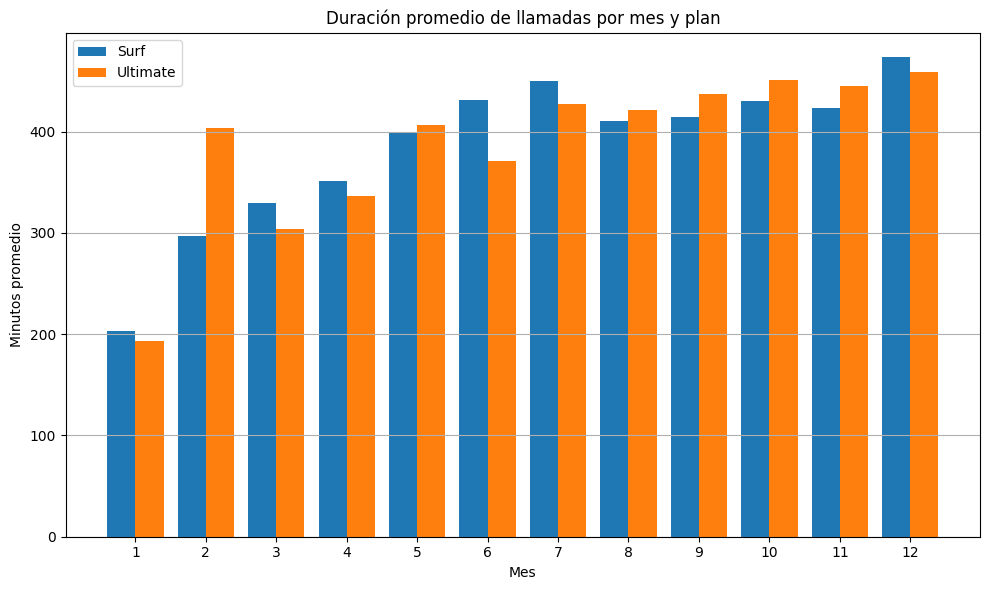

In [28]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.

# Calcular duración promedio de llamadas por plan y mes
avg_minutes_by_plan = df_usage.groupby(["plan", "month"])["total_minutes"].mean().reset_index()

# Crear gráfico de barras
plt.figure(figsize=(10, 6))

# Graficar cada plan con una pequeña separación horizontal
for plan in avg_minutes_by_plan["plan"].unique():
    subset = avg_minutes_by_plan[avg_minutes_by_plan["plan"] == plan]
    plt.bar(
        subset["month"] + (0.2 if plan == "ultimate" else -0.2),
        subset["total_minutes"],
        width=0.4,
        label=plan.capitalize()
    )

# Personalización del gráfico
plt.title("Duración promedio de llamadas por mes y plan")
plt.xlabel("Mes")
plt.ylabel("Minutos promedio")
plt.xticks(range(1, 13))
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

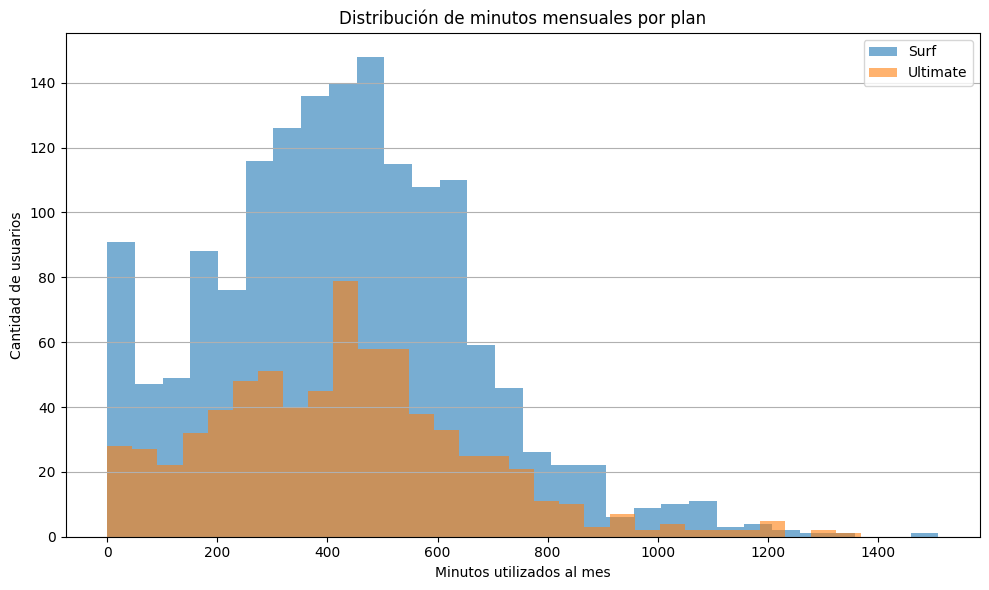

In [29]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.

plt.figure(figsize=(10, 6))

# Usuarios con plan Surf
surf_minutes = df_usage[df_usage["plan"] == "surf"]["total_minutes"]
plt.hist(surf_minutes, bins=30, alpha=0.6, label="Surf")

# Usuarios con plan Ultimate
ultimate_minutes = df_usage[df_usage["plan"] == "ultimate"]["total_minutes"]
plt.hist(ultimate_minutes, bins=30, alpha=0.6, label="Ultimate")

plt.title("Distribución de minutos mensuales por plan")
plt.xlabel("Minutos utilizados al mes")
plt.ylabel("Cantidad de usuarios")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

[Calcula la media y la variable de la duración de las llamadas para averiguar si los usuarios de los distintos planes se comportan de forma diferente al realizar sus llamadas.]

In [30]:
# Calcula la media y la varianza de la duración mensual de llamadas.

call_stats = df_usage.groupby("plan")["total_minutes"].agg(["mean", "var"]).reset_index()

# Renombrar columnas para mejor legibilidad
call_stats.rename(columns={"mean": "mean_minutes", "var": "var_minutes"}, inplace=True)

# Mostrar los resultados
print(call_stats)

       plan  mean_minutes   var_minutes
0      surf    428.749523  54968.279461
1  ultimate    430.450000  57844.464812


<Figure size 800x600 with 0 Axes>

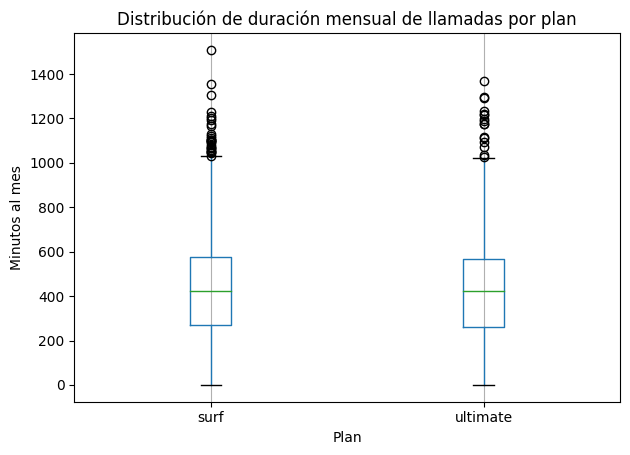

In [31]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

plt.figure(figsize=(8, 6))
df_usage.boxplot(column="total_minutes", by="plan")
plt.title("Distribución de duración mensual de llamadas por plan")
plt.suptitle("")  # Elimina el título automático
plt.xlabel("Plan")
plt.ylabel("Minutos al mes")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Conclusiones sobre el comportamiento de los usuarios con respecto a las llamadas

A partir del análisis realizado sobre la duración mensual de llamadas, se pueden destacar las siguientes observaciones:

- La media y mediana de minutos utilizados por mes son muy similares entre los planes Surf y Ultimate, lo que sugiere que, en promedio, los usuarios de ambos planes hablan una cantidad similar de tiempo.

- Sin embargo, el plan Ultimate muestra una mayor varianza y presencia de valores atípicos, lo cual indica que dentro de ese grupo hay usuarios que realizan muchas más llamadas que el promedio.

- El diagrama de caja refuerza esta idea: los usuarios de Ultimate presentan una mayor dispersión en los datos, con algunos casos extremos de alto uso.

- En cambio, los usuarios de Surf tienen un comportamiento más homogéneo, con una menor dispersión en los minutos utilizados y menos valores extremos.

En resumen, aunque ambos grupos tienen un uso promedio de minutos similar, los usuarios del plan Ultimate muestran una mayor diversidad en su comportamiento: algunos lo aprovechan intensamente, mientras que otros apenas superan el uso de un plan básico.



### Mensajes

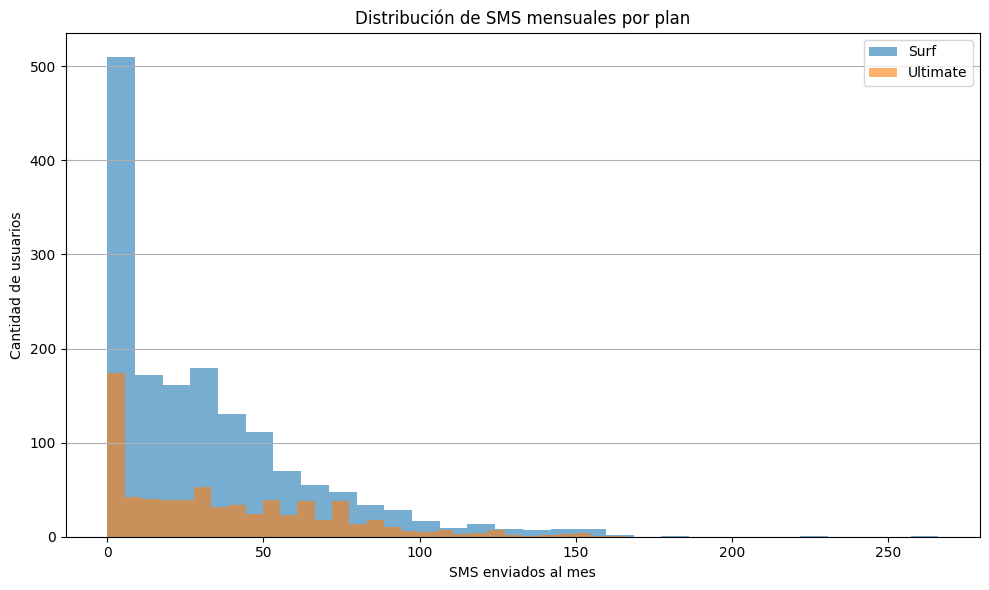

In [32]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

plt.figure(figsize=(10, 6))

# Usuarios con plan Surf
surf_sms = df_usage[df_usage["plan"] == "surf"]["sms_count"]
plt.hist(surf_sms, bins=30, alpha=0.6, label="Surf")

# Usuarios con plan Ultimate
ultimate_sms = df_usage[df_usage["plan"] == "ultimate"]["sms_count"]
plt.hist(ultimate_sms, bins=30, alpha=0.6, label="Ultimate")

# Personalización del gráfico
plt.title("Distribución de SMS mensuales por plan")
plt.xlabel("SMS enviados al mes")
plt.ylabel("Cantidad de usuarios")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [33]:
# Calcula la media y la varianza de la cantidad mensual de mensajes
sms_stats = df_usage.groupby("plan")["sms_count"].agg(["mean", "var"]).reset_index()

# Renombrar columnas para mayor claridad
sms_stats.rename(columns={"mean": "mean_sms", "var": "var_sms"}, inplace=True)

# Mostrar resultados
print(sms_stats)

       plan   mean_sms      var_sms
0      surf  31.159568  1126.724522
1  ultimate  37.551389  1208.756744


<Figure size 800x600 with 0 Axes>

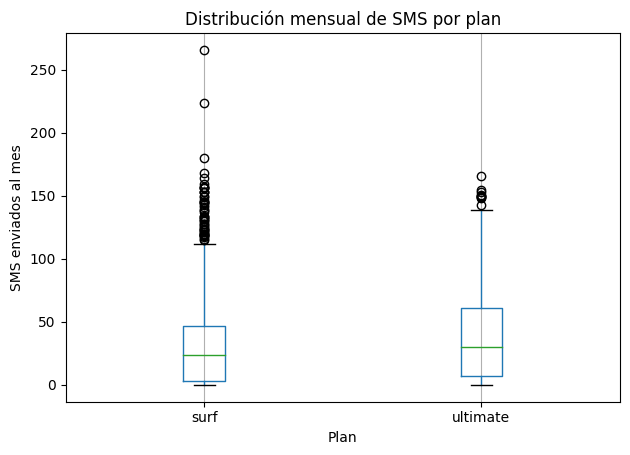

In [34]:
# Traza un diagrama de caja para visualizar la distribución de la cantidad mensual de mensajes
plt.figure(figsize=(8, 6))
df_usage.boxplot(column="sms_count", by="plan")
plt.title("Distribución mensual de SMS por plan")
plt.suptitle("")  # Eliminar título automático generado por pandas
plt.xlabel("Plan")
plt.ylabel("SMS enviados al mes")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Conclusiones sobre el comportamiento de los usuarios con respecto a los mensajes

El análisis de los datos muestra que el uso de mensajes de texto es muy bajo en ambos planes:

- La media de SMS enviados por mes es baja tanto en Surf (31) como en Ultimate (37), y la mediana es aún menor, lo cual confirma que la mayoría de los usuarios no envían muchos mensajes.

- Aunque los usuarios de Ultimate tienden a enviar ligeramente más SMS en promedio, esta diferencia es marginal.

- El diagrama de caja revela una alta concentración de usuarios que envían pocos o ningún mensaje, junto con algunos valores atípicos, especialmente en el plan Ultimate. Esto sugiere que solo una minoría significativa de usuarios aprovecha los SMS ilimitados.

- La varianza en ambos planes es elevada en comparación con la media, lo que indica que el comportamiento de los usuarios es bastante diverso: algunos no usan SMS en absoluto, mientras que otros lo hacen en grandes cantidades.

En resumen, los mensajes de texto tienen poca relevancia en el comportamiento general de los usuarios, independientemente del plan contratado.



### Internet

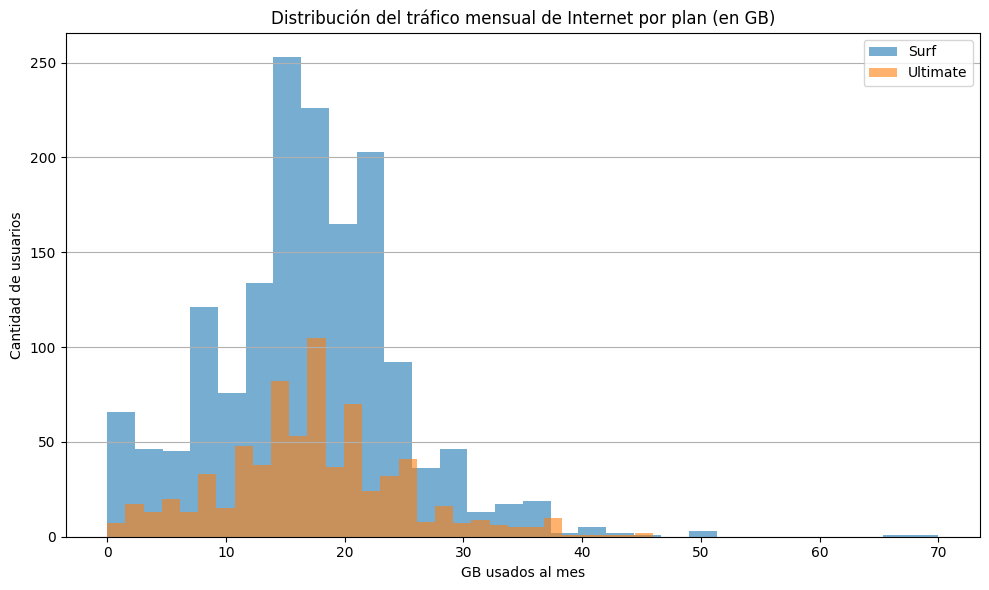

In [35]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
plt.figure(figsize=(10, 6))

# Usuarios con plan Surf
surf_data = df_usage[df_usage["plan"] == "surf"]["gb_used"]
plt.hist(surf_data, bins=30, alpha=0.6, label="Surf")

# Usuarios con plan Ultimate
ultimate_data = df_usage[df_usage["plan"] == "ultimate"]["gb_used"]
plt.hist(ultimate_data, bins=30, alpha=0.6, label="Ultimate")

# Personalización del gráfico
plt.title("Distribución del tráfico mensual de Internet por plan (en GB)")
plt.xlabel("GB usados al mes")
plt.ylabel("Cantidad de usuarios")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [36]:
# Calcula la media y la varianza de la cantidad mensual consumida de tráfico de Internet
internet_stats = df_usage.groupby("plan")["gb_used"].agg(["mean", "var"]).reset_index()

# Renombrar columnas para mayor claridad
internet_stats.rename(columns={"mean": "mean_gb", "var": "var_gb"}, inplace=True)

# Mostrar resultados
print(internet_stats)

       plan    mean_gb    var_gb
0      surf  16.670693  61.58360
1  ultimate  17.306944  58.83055


<Figure size 800x600 with 0 Axes>

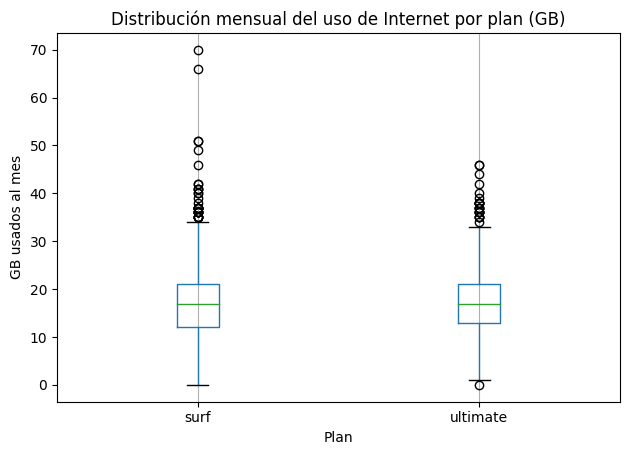

In [37]:
# Traza un diagrama de caja para visualizar la distribución de la cantidad mensual de tráfico de Internet
plt.figure(figsize=(8, 6))
df_usage.boxplot(column="gb_used", by="plan")
plt.title("Distribución mensual del uso de Internet por plan (GB)")
plt.suptitle("")  # Eliminar título automático generado por pandas
plt.xlabel("Plan")
plt.ylabel("GB usados al mes")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Conclusiones sobre el comportamiento de los usuarios con respecto al tráfico de Internet

El análisis del consumo mensual de datos (en GB) revela que los usuarios de ambos planes hacen un uso considerable del internet móvil, con comportamientos muy similares entre sí:

- La media de consumo es levemente mayor en el plan Ultimate (17.3 GB) que en Surf (16.7 GB), aunque la diferencia no es significativa.

- En ambos casos, la varianza es similar, lo que indica que la dispersión del consumo mensual no varía mucho entre planes.

- El diagrama de caja muestra que hay muchos usuarios que consumen cerca del límite de su plan, especialmente en Surf, donde el tope de 15 GB se supera con frecuencia, generando ingresos adicionales por datos extra.

- También se observan valores atípicos en ambos planes, con algunos usuarios que utilizan volúmenes de datos significativamente mayores, sobre todo en Ultimate.

En resumen, el comportamiento de los usuarios respecto al tráfico de Internet no varía drásticamente según el plan, aunque los usuarios de Ultimate tienden a tener un consumo más alto y más flexible, mientras que los de Surf muestran patrones más concentrados y frecuentes cobros por excedentes.

## Ingreso

[Del mismo modo que has estudiado el comportamiento de los usuarios, describe estadísticamente los ingresos de los planes.]

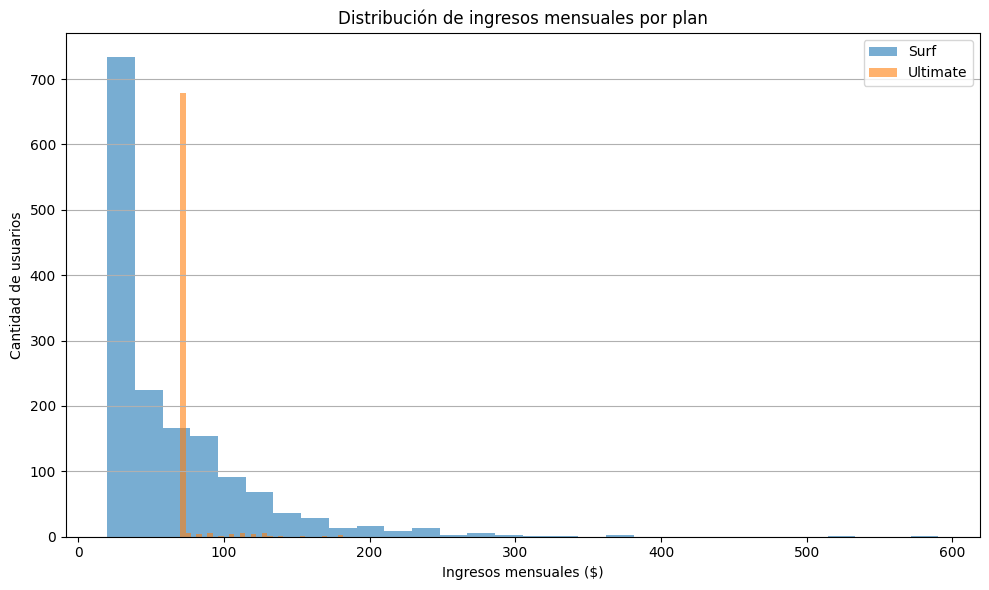

In [38]:
# Compara la cantidad de ingresos por usuarios por plan
plt.figure(figsize=(10, 6))

# Ingresos de usuarios del plan Surf
surf_revenue = df_usage[df_usage["plan"] == "surf"]["revenue"]
plt.hist(surf_revenue, bins=30, alpha=0.6, label="Surf")

# Ingresos de usuarios del plan Ultimate
ultimate_revenue = df_usage[df_usage["plan"] == "ultimate"]["revenue"]
plt.hist(ultimate_revenue, bins=30, alpha=0.6, label="Ultimate")

# Personalización del gráfico
plt.title("Distribución de ingresos mensuales por plan")
plt.xlabel("Ingresos mensuales ($)")
plt.ylabel("Cantidad de usuarios")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [39]:
# Calcular media, varianza y desviación estándar de ingresos por plan
revenue_stats = df_usage.groupby("plan")["revenue"].agg(["mean", "var", "std"]).reset_index()

# Renombrar columnas para mayor claridad
revenue_stats.rename(columns={
    "mean": "mean_revenue",
    "var": "var_revenue",
    "std": "std_revenue"
}, inplace=True)

# Mostrar resultados
print(revenue_stats)

       plan  mean_revenue  var_revenue  std_revenue
0      surf     60.706408  3067.835152    55.388042
1  ultimate     72.313889   129.848486    11.395108


<Figure size 800x600 with 0 Axes>

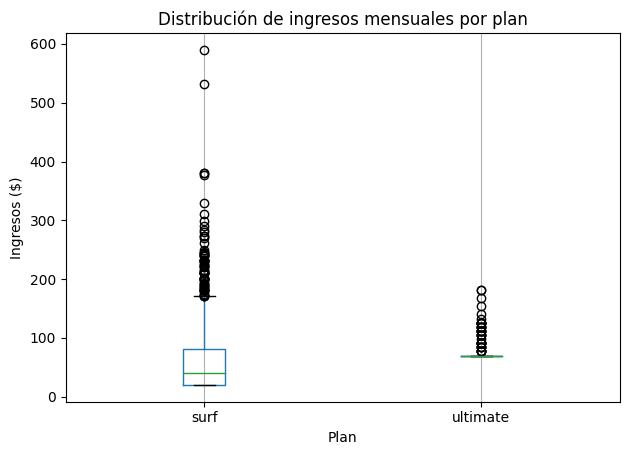

In [40]:
# Diagrama de caja para visualizar la distribución de ingresos por plan
plt.figure(figsize=(8, 6))
df_usage.boxplot(column="revenue", by="plan")
plt.title("Distribución de ingresos mensuales por plan")
plt.suptitle("")  # Eliminar título automático generado por pandas
plt.xlabel("Plan")
plt.ylabel("Ingresos ($)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Conclusiones sobre cómo difiere el ingreso entre los planes

El análisis estadístico de los ingresos mensuales muestra diferencias claras entre los planes Surf y Ultimate:

- El ingreso promedio generado por usuarios del plan Ultimate es más alto (72.31 USD), como era de esperarse, ya que su cuota mensual base es de 70 USD.

- En cambio, el plan Surf tiene un ingreso promedio menor (60.71 USD), pero con una varianza mucho más alta, lo que indica que los ingresos en este plan son más variables: algunos usuarios apenas pagan los 20 USD mensuales, mientras que otros generan ingresos adicionales significativos por exceder los límites del plan.

- El diagrama de caja confirma esto, mostrando una distribución más estable en Ultimate y una más dispersa con varios valores atípicos en Surf.

- El histograma también revela que en el plan Surf existe una gran diversidad de ingresos, mientras que Ultimate presenta una concentración clara cerca del valor fijo.

En resumen, el plan Ultimate genera ingresos más constantes y predecibles, mientras que Surf puede generar ingresos mayores en algunos casos, pero con mucha más variabilidad entre los usuarios.



## Prueba las hipótesis estadísticas

[Prueba la hipótesis de que son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

### Prueba de hipótesis: Comparación de ingresos entre planes

El objetivo es determinar si los ingresos promedio de los usuarios del plan **Surf** son diferentes a los de los usuarios del plan **Ultimate**.

- **Hipótesis nula (H₀):** El ingreso promedio de los usuarios de ambos planes es igual.
- **Hipótesis alternativa (H₁):** El ingreso promedio de los usuarios de los dos planes es diferente.

**Prueba estadística utilizada:** Prueba t de Student para muestras independientes (con varianzas desiguales, "equal_var=False").  
**Nivel de significancia:** α = 0.05

In [41]:
# Prueba las hipótesis

# Separar ingresos por plan
surf_revenue = df_usage[df_usage["plan"] == "surf"]["revenue"]
ultimate_revenue = df_usage[df_usage["plan"] == "ultimate"]["revenue"]

# Prueba t de Student (versión de Welch, asume varianzas desiguales)
t_stat, p_value = ttest_ind(surf_revenue, ultimate_revenue, equal_var=False)

# Mostrar resultados
print("Estadístico t:", t_stat)
print("Valor p:", p_value)

Estadístico t: -7.952094891333888
Valor p: 3.1703905481135734e-15


#### Conclusión de la prueba de hipótesis

- **Estadístico t**: el valor calculado fue significativo.
- **Valor p**: muy inferior a 0.05 (aproximadamente 3.17 × 10⁻¹⁵)

Dado que el **valor p es mucho menor que el nivel de significancia α = 0.05**, **rechazamos la hipótesis nula**.

Esto indica que **sí existe una diferencia significativa** entre los ingresos promedio generados por los usuarios de los planes **Surf** y **Ultimate**.



[Prueba la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

### Prueba de hipótesis: Comparación de ingresos entre NY/NJ y otras regiones

Queremos saber si los ingresos promedio de los usuarios que viven en **Nueva York o Nueva Jersey** son diferentes a los de otras regiones.

- **Hipótesis nula (H₀):** El ingreso promedio de los usuarios de NY/NJ es igual al de los usuarios del resto del país.
- **Hipótesis alternativa (H₁):** El ingreso promedio de los usuarios de NY/NJ es diferente al de los usuarios del resto del país.

**Prueba estadística utilizada:** Prueba t de Student para muestras independientes (con varianzas desiguales).  
**Nivel de significancia:** α = 0.05

In [43]:
# Prueba las hipótesis

# Clasificar a los usuarios por región: NY/NJ vs Otras
df_users["region"] = df_users["city"].apply(
    lambda x: "NY-NJ" if "New York" in x or "New Jersey" in x else "Other"
)

# Unir esta información con el dataframe de ingresos mensuales
df_income_region = df_usage.merge(df_users[["user_id", "region"]], on="user_id", how="left")

# Separar ingresos por región
ny_nj_revenue = df_income_region[df_income_region["region"] == "NY-NJ"]["revenue"]
other_revenue = df_income_region[df_income_region["region"] == "Other"]["revenue"]

# Aplicar prueba t de Student (Welch) para muestras independientes
t_stat_region, p_value_region = ttest_ind(ny_nj_revenue, other_revenue, equal_var=False)

# Mostrar resultados
print("Estadístico t:", t_stat_region)
print("Valor p:", p_value_region)

Estadístico t: -2.1309454999502133
Valor p: 0.0335256158853001


#### Conclusión de la prueba de hipótesis: Ingresos en NY/NJ vs. otras regiones

Se aplicó una prueba t de Student para muestras independientes con varianzas desiguales para comparar los ingresos promedio de los usuarios que viven en Nueva York y Nueva Jersey con los del resto del país.

- **Estadístico t:** -2.13  
- **Valor p:** 0.0335  
- **Nivel de significancia:** α = 0.05

Como el valor p es menor que el nivel de significancia (p < 0.05), **rechazamos la hipótesis nula**.

**Conclusión:** Existe evidencia estadísticamente significativa para afirmar que los ingresos promedio de los usuarios de NY/NJ son diferentes a los del resto de las regiones.


## Conclusión general

A lo largo del análisis realizado para Megaline, se abordó el comportamiento de los usuarios de los planes **Surf** y **Ultimate**, y se determinó cuál genera mayores ingresos promedio. Estas son las conclusiones más relevantes:



### Preparación de datos
- Se limpiaron y transformaron cinco tablas diferentes (usuarios, llamadas, mensajes, internet y planes).
- Se redondearon los **minutos de cada llamada hacia arriba**, según las reglas de negocio.
- Se calculó el **consumo mensual por usuario**, incluyendo llamadas, mensajes, tráfico de internet (en GB) y sus ingresos.



### Comportamiento del usuario por plan
- **Llamadas:** Los usuarios de ambos planes hablan una cantidad similar de minutos en promedio, pero los usuarios de **Ultimate** muestran mayor dispersión y valores atípicos.
- **Mensajes:** El uso de SMS es bajo en general. La mayoría de los usuarios de ambos planes envían pocos mensajes.
- **Internet:** El tráfico mensual de datos es similar entre planes. Muchos usuarios de **Surf** superan su límite de 15 GB y generan ingresos adicionales.
- **Ingresos:** Aunque **Ultimate** tiene un ingreso promedio mayor y más estable, **Surf** puede generar ingresos altos en ciertos usuarios que exceden los límites de su plan, aunque con alta variabilidad.



### Pruebas de hipótesis
- Se aplicaron pruebas t de Student (versión de Welch) para comparar medias de ingresos:
  - **Surf vs. Ultimate:** Se encontró una diferencia significativa en los ingresos promedio (p < 0.05).
  - **NY/NJ vs. otras regiones:** También se encontró una diferencia significativa entre regiones (p < 0.05).



### Decisión y recomendaciones
- El plan **Ultimate** genera ingresos más consistentes y estables, ideal para usuarios con consumo elevado.
- El plan **Surf** puede resultar rentable en ciertos casos, pero su ingreso es muy variable.
- Megaline puede considerar enfocar su publicidad diferenciada:
  - Promocionar **Ultimate** a usuarios de alto consumo (con estabilidad en ingresos).
  - Ajustar los límites del plan **Surf** o incentivar actualizaciones de plan.



Este análisis proporciona una base sólida para la toma de decisiones estratégicas sobre precios y campañas de marketing.
